In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func
from datetime import datetime
from datetime import timedelta


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)


C:\Users\Guest1\AppData\Local\Temp\ipykernel_38720\394816113.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# Print all of the classes mapped to the Base
mapped_classes = Base.classes.keys()
print(mapped_classes)

['station', 'measurement']


In [7]:
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

# the station class to a variable called `Station`
station = Base.classes.station

In [8]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most recent date in the dataset:", most_recent_date)

Most recent date in the dataset: 2017-08-23


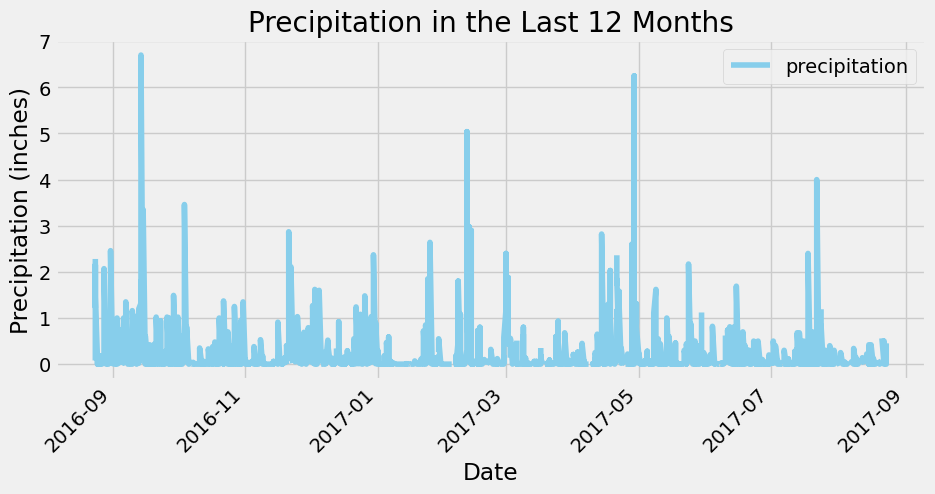

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date
# Calculate the date one year from the last date in data set.
last_year_date = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)
last_year_date

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])


# Sort the dataframe by date
last_year_df['date'] = pd.to_datetime(last_year_df['date'])
#last_year_df.set_index('date', inplace=True)
last_year_df

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot( x = 'date', y = 'precipitation', figsize=(10, 5), color='skyblue')

# Set the title and labels
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Show the plot
plt.xticks(rotation=45)  
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = last_year_df.describe()
summary_statistics


,date,precipitation
count,2223,2015.000000
mean,2017-02-16 18:54:53.927125248,0.176462
min,2016-08-24 00:00:00,0.000000
25%,2016-11-19 00:00:00,0.000000
50%,2017-02-15 00:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.460288


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.id).label('observation_count')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

# List the stations and their counts in descending order.

for station, count in most_active_stations:
    print(f'Station ID: {station}, Observation Count: {count}')






Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# Query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Print the results
for min_temp, max_temp, avg_temp in temperature_stats:
    print(f'Lowest Temperature: {min_temp}')
    print(f'Highest Temperature: {max_temp}')
    print(f'Average Temperature: {avg_temp}')


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


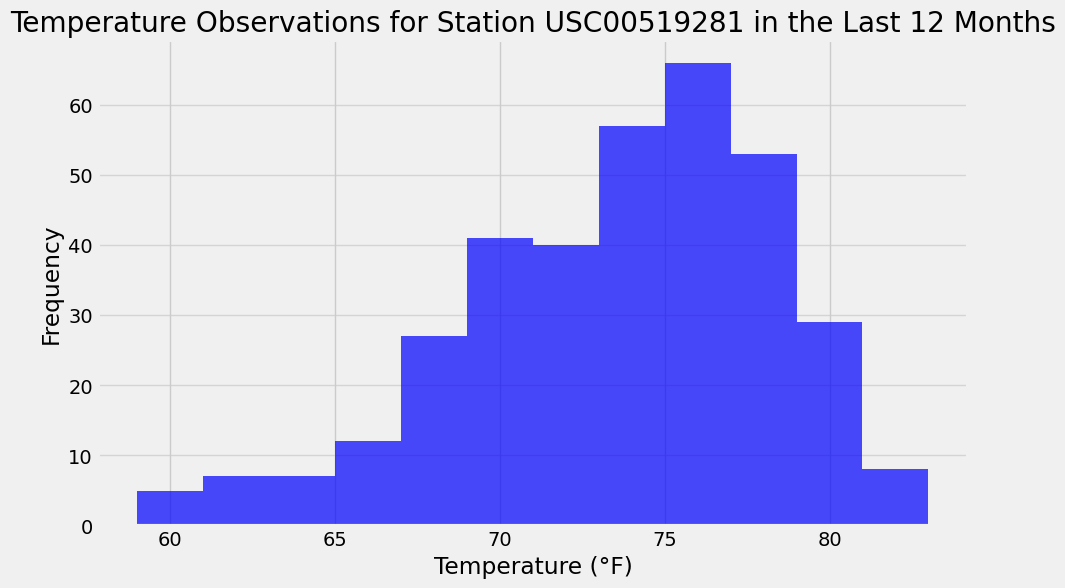

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_id = 'USC00519281'
max_date = dt.date (2017,8,23)
# Calculate the date for 12 months ago
last_year_date = max_date - timedelta(days=365)
last_year_date
# Query to get the last 12 months of temperature observation data for the most active station
last_12_months_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= last_year_date
).all()

# Convert the results to a Pandas DataFrame
temperature_data = pd.DataFrame(last_12_months_data, columns=['tobs'])
temperature_data
#Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_data['tobs'], bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station_id} in the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()



# Close Session

In [96]:
# Close Session
session.close()
